### Authenticating with Hugging Face

In [ ]:
# ⬇️ Run this cell once
from ipywidgets import Password, Button, HBox, Output
import os, pathlib
import sys

from huggingface_hub import HfFolder, whoami

# ---- UI widgets ----
token_box = Password(
    description="HF Token:",
    placeholder="paste your Hugging Face token here",
    layout={"width": "450px"},
)
save_btn = Button(description="Save", button_style="success")
out = Output()

# ---- Callback ----
def save_token(_):
    out.clear_output()
    token = token_box.value.strip()
    with out:
        if not token:
            print("❌ No token entered.")
            return
        # Persist token
        HfFolder.save_token(token)                 # writes to ~/.cache/huggingface/token
        os.environ["HF_TOKEN"] = token             # current kernel env (optional)
        # Sanity-check who we are
        try:
            user = whoami(token)["name"]
            print(f"✅ Token saved. Logged in as: {user}")
        except Exception as e:
            print("⚠️ Token saved, but user lookup failed:", e)

save_btn.on_click(save_token)

display(HBox([token_box, save_btn]), out)

In [2]:
!pip install vllm

INFO: pip is looking at multiple versions of model-hosting-container-standards to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.5/466.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.0/355.0 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import torch
torch.cuda.is_available()

True

### Loading the model

For the experiments in this tutorial we will be using [nvidia/NVIDIA-Nemotron-Nano-9B-v2](https://huggingface.co/nvidia/NVIDIA-Nemotron-Nano-9B-v2), a large language model (LLM) trained from scratch by NVIDIA, and designed as a unified model for both reasoning and non-reasoning tasks.

In [2]:
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams
import os

MODEL_ID = "nvidia/Llama-3.1-Nemotron-Nano-4B-v1.1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)

tp = int(os.getenv("TP_SIZE", "1"))  # set >1 if you want tensor parallel across GPUs

llm = LLM(
    model=MODEL_ID,
    dtype="float16",
    trust_remote_code=True,
    tensor_parallel_size=tp,
    max_num_seqs=64,
    max_model_len=131072,
    mamba_ssm_cache_dtype="float32",
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

INFO 12-08 11:34:18 [utils.py:253] non-default args: {'trust_remote_code': True, 'dtype': 'float16', 'seed': None, 'max_model_len': 131072, 'max_num_seqs': 64, 'disable_log_stats': True, 'mamba_ssm_cache_dtype': 'float32', 'model': 'nvidia/Llama-3.1-Nemotron-Nano-4B-v1.1'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json:   0%|          | 0.00/910 [00:00<?, ?B/s]

WARNING 12-08 11:34:18 [arg_utils.py:1175] `seed=None` is equivalent to `seed=0` in V1 Engine. You will no longer be allowed to pass `None` in v0.13.
INFO 12-08 11:34:37 [model.py:637] Resolved architecture: LlamaForCausalLM
WARNING 12-08 11:34:37 [model.py:2089] Casting torch.bfloat16 to torch.float16.
INFO 12-08 11:34:37 [model.py:1750] Using max model len 131072
INFO 12-08 11:34:40 [scheduler.py:228] Chunked prefill is enabled with max_num_batched_tokens=8192.


generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

WARNING 12-08 11:34:42 [system_utils.py:136] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 12-08 11:36:36 [llm.py:343] Supported tasks: ['generate']


In [3]:
sampling = SamplingParams(
    max_tokens=512, temperature=0.7, top_p=0.9
)

In [4]:
def to_chat(messages):
    """
    messages = [
      {"role": "system", "content": "/no_think"},   # or "/think"
      {"role": "user",   "content": "Write a haiku about GPUs"}
    ]
    """
    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        return_tensors="pt"
    )

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import string
from tqdm import tqdm

DISTANCES = [1000, 2000, 8000, 16000, 32000]
POSITIONS = ["middle", "start", "end"]

SECRET_FACT = "THE SECRET CODE IS 4711"
QUESTION = "What is the secret code?"
GROUND_TRUTH = "4711"


In [6]:
# Вспомогательная функция: генерирует случайный шум
def make_noise(n_tokens):
    # Просто генерируем n_tokens слов
    words = []
    for _ in range(n_tokens):
        w = ''.join(random.choices(string.ascii_lowercase, k=5))
        words.append(w)
    return " ".join(words)

In [7]:
def build_context(distance, position, fact):
    """Создаёт контекст, где секрет спрятан на указанной позиции."""
    noise_before = make_noise(distance // 2)
    noise_after = make_noise(distance // 2)

    if position == "start":
        context = f"{fact}\n{make_noise(distance)}"
    elif position == "middle":
        context = f"{noise_before}\n{fact}\n{noise_after}"
    elif position == "end":
        context = f"{make_noise(distance)}\n{fact}"
    else:
        raise ValueError("invalid position")

    return context

In [8]:
def ask_model(context, question):
    messages = [
        {"role": "system", "content": "/no_think"},
        {"role": "user",   "content": context + "\n\n" + question}
    ]
    chat_prompt = to_chat(messages)

    outs = llm.generate([chat_prompt], sampling)
    output = outs[0].outputs[0].text.strip()
    return output

def check_answer(output, truth):
    return truth.lower() in output.lower()

In [9]:
results = []
questions = [
    ("The secret code is 5999", "What is the secret code?", "5999"),
    ("The main ingredient in the recipe was Cardamom", "What is the main ingredient in the recipe?", "Cardamom"),
    ("The city where the summit took place was Rotterdam", "What city was chosen for the summit?", "Rotterdam"),
    ("A module with the id MX-3041 is missing", "What is the identifier of the missing module?", "MX-3041"),
    ("A restricted folger was marked with an amber tag", "What color tag marks the restricted folder?", "Amber"),
]

for pos in POSITIONS:
    for i, dist in enumerate(DISTANCES):
        context = build_context(dist, pos, questions[i][0])
        output = ask_model(context, questions[i][1])
        acc = 1 if check_answer(output, questions[i][2]) else 0

        results.append({
            "position": pos,
            "distance": dist,
            "accuracy": acc,
            "output": output,
        })

        print(f"[{pos}] {dist} tokens → acc={acc} | out={output[:60]}...")

df = pd.DataFrame(results)

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[middle] 1000 tokens → acc=1 | out=<think>
Okay, let's try to figure out the secret code from t...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[middle] 2000 tokens → acc=1 | out=<think>
Okay, let's tackle this query. The user provided a l...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[middle] 8000 tokens → acc=1 | out=<think>Okay, let's try to figure out the answer to this ques...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[middle] 16000 tokens → acc=0 | out=<think>Okay, let me try to figure out the answer to this que...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[middle] 32000 tokens → acc=1 | out=<think>
Okay, let's tackle this query. The user is asking, "...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[start] 1000 tokens → acc=1 | out=<think>
Okay, so the user provided a lengthy string of text ...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[start] 2000 tokens → acc=1 | out=<think>
Okay, let's take a look at this query. The user prov...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[start] 8000 tokens → acc=1 | out=<think>Okay, let's tackle this question. The user provided a...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[start] 16000 tokens → acc=1 | out=<think>Okay, let's tackle this query step by step. The user ...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[start] 32000 tokens → acc=1 | out=<think>Okay, let's tackle this query. The user asked, "What ...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[end] 1000 tokens → acc=1 | out=<think>
Okay, let's take a look at this query. The user prov...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[end] 2000 tokens → acc=1 | out=<think>Okay, let's tackle this query. The user provided a lo...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[end] 8000 tokens → acc=1 | out=<think>Okay, let's tackle this question. The user provided a...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[end] 16000 tokens → acc=1 | out=<think>Okay, let's try to figure out the identifier of the m...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[end] 32000 tokens → acc=1 | out=<think>Okay, let's try to figure out what color the amber ta...


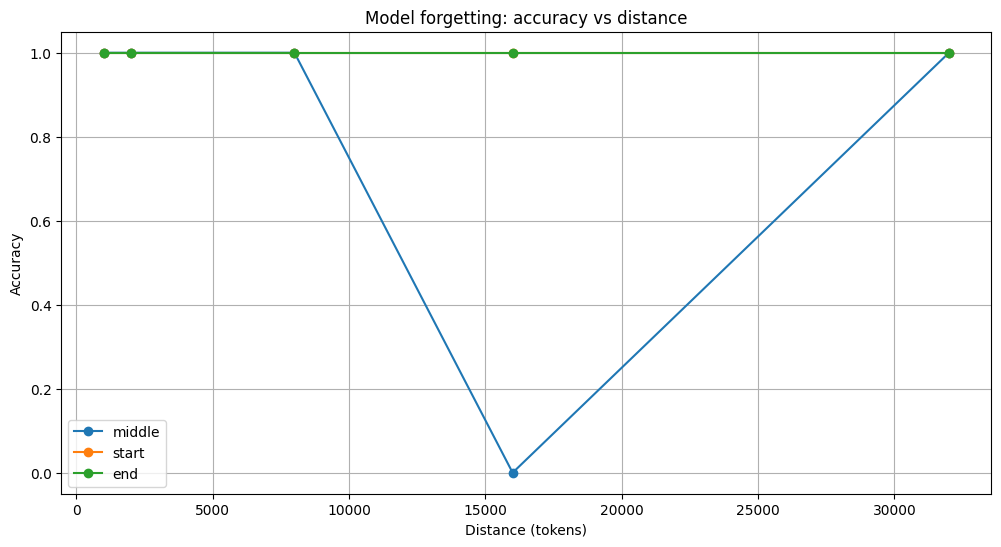


DONE. DF:
   position  distance  accuracy  \
0    middle      1000         1   
1    middle      2000         1   
2    middle      8000         1   
3    middle     16000         0   
4    middle     32000         1   
5     start      1000         1   
6     start      2000         1   
7     start      8000         1   
8     start     16000         1   
9     start     32000         1   
10      end      1000         1   
11      end      2000         1   
12      end      8000         1   
13      end     16000         1   
14      end     32000         1   

                                               output  
0   <think>\nOkay, let's try to figure out the sec...  
1   <think>\nOkay, let's tackle this query. The us...  
2   <think>Okay, let's try to figure out the answe...  
3   <think>Okay, let me try to figure out the answ...  
4   <think>\nOkay, let's tackle this query. The us...  
5   <think>\nOkay, so the user provided a lengthy ...  
6   <think>\nOkay, let's take a look

In [10]:
plt.figure(figsize=(12, 6))

for pos in POSITIONS:
    sub = df[df["position"] == pos]
    plt.plot(sub["distance"], sub["accuracy"], marker="o", label=pos)

plt.xlabel("Distance (tokens)")
plt.ylabel("Accuracy")
plt.title("Model forgetting: accuracy vs distance")
plt.grid(True)
plt.legend()
plt.show()

print("\nDONE. DF:")
print(df)

In [ ]:
# Chat prompt with reasoning OFF
messages = [
    {"role":"system", "content": "/no_think"},
    {"role":"user",   "content": "Explain KV cache in one paragraph."}
]
chat_prompt = to_chat(messages)

outs = llm.generate([chat_prompt], sampling)
for i, o in enumerate(outs, 1):
    print(f"=== Output {i} ===\n{o.outputs[0].text}\n")

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

=== Output 1 ===
A KV cache, or key-value cache, is a data structure used in machine learning, particularly in transformer-based models like GPT, to store and efficiently manage the key-value pairs generated during the attention mechanism. It allows the model to retain and quickly access previously computed information during sequence generation, reducing redundant computations and accelerating the process of predicting subsequent tokens in a sequence.




## Stop this notebook

Make sure to restart the jupyter kernel before proceeding with next exercises.

In [ ]:
import os
os._exit(0)